In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nasdaqdatalink as ndl
import json

import numpy as np
from typing import List, Callable, Dict
from realgam.quantlib import general_utils as gu
from realgam.quantlib.engineer.op_engineer_vect import OpEngineerV
from realgam.quantlib.engineer.ta_engineer_vect import TalibEngineerV
from realgam.quantlib.engineer.alpha_engineer_vect import AlphaEngineerV
from realgam.quantlib.engineer.test_no_class import alpha001, ts_ret
import talib
from joblib import Parallel, delayed
from datetime import datetime, timedelta
import os
import time
PROJECT_PATH = os.getenv('QuantSystemMVP')
BACKTEST_PATH = f'{PROJECT_PATH}/Backtest_Data'
DATA_PATH = f'{PROJECT_PATH}/Data/historical/stock_hist_perma.obj'
ENG_PATH = f'{PROJECT_PATH}/Data/engineered/e_alpha_20220401.obj'
NDL_CONFIG_PATH = f'{PROJECT_PATH}/realgam/quantlib/nasdaq_dl_config.json'
NDL_CONFIG = json.load(open(NDL_CONFIG_PATH))

In [2]:
N = 365 * 2
PRIMARY_KEY = 'permaticker'

In [3]:
# print("Fetching ticker metadata")
# ticker_info = ndl.get_table('SHARADAR/TICKERS', paginate=True)
#
# print("Loading historical data")
# stocks_df, _, _ = gu.load_file(DATA_PATH)
# stocks_df = stocks_df.reset_index()
#
# date_N_ago = (datetime.now() - timedelta(days=N))
#
# eod_focus = stocks_df[stocks_df.date > date_N_ago]
# available_tickers = eod_focus[['permaticker', 'ticker']].drop_duplicates(keep='last')
# latest_ticker_universe_pair = available_tickers.drop_duplicates('permaticker', keep='last')
# latest_permatickers = list(latest_ticker_universe_pair['permaticker'])
# latest_tickers = list(latest_ticker_universe_pair['ticker'])
#
# symbol_name_converter = {}
# for permaticker, ticker in zip(latest_permatickers, latest_tickers):
#     symbol_name_converter[permaticker] = ticker
#     symbol_name_converter[ticker] = permaticker
#
# eod_focus.sort_values(['permaticker', 'date'], inplace=True)
#
# # Calculate ma’s, 52w high and low
# eod_focus['ma_50'] = eod_focus.groupby('ticker').rolling(50).closeadj.mean().values
# eod_focus['ma_150'] = eod_focus.groupby('ticker').rolling(150).closeadj.mean().values
# eod_focus['ma_200'] = eod_focus.groupby('ticker').rolling(200).closeadj.mean().values
# eod_focus['w52_high'] = eod_focus.groupby('ticker').rolling(200).closeadj.max().values
# eod_focus['w52_low'] = eod_focus.groupby('ticker').rolling(200).closeadj.min().values
#
# # Calculate pct change for various metrics necessary for trend template
# eod_focus['ma_200_lag1m'] = eod_focus.groupby('ticker').ma_200.shift(25)
# eod_focus['ma_200_lag5m'] = eod_focus.groupby('ticker').ma_200.shift(110)
# eod_focus['w52_low_pct_diff'] = eod_focus.closeadj / eod_focus.w52_low - 1
# eod_focus['w52_high_pct_diff'] = (eod_focus.closeadj / eod_focus.w52_high - 1).abs()
# eod_focus['close_lag1y'] = eod_focus.groupby('ticker').closeadj.shift(252)
# eod_focus['annual_ret'] = eod_focus.closeadj / eod_focus.close_lag1y - 1


Fetching ticker metadata
Loading historical data


In [66]:
import talib as ta

def BBANDSG(df, period, multBB):
    upper, middle, low = ta.BBANDS(df.closeadj, timeperiod=period, nbdevup=multBB, nbdevdn=multBB, matype=0)

    return  pd.DataFrame({'bb_up':upper, 'bb_mid':middle, 'bb_dn':low}, index=df.index)

def ATRG(df, period):

    atr = ta.ATR(df.highadj, df.lowadj, df.closeadj, timeperiod=period)
    return pd.DataFrame({'atr':atr}, index=df.index)

def KCG(df, multKC):

    upper = df.bb_mid.add(df.atr.mul(multKC))
    lower = df.bb_mid.subtract(df.atr.mul(multKC))
    return pd.DataFrame({'upper_kc': upper, 'lower_kc': lower}, index=df.index)






In [ ]:
print("Fetching ticker metadata")
ticker_info = ndl.get_table('SHARADAR/TICKERS', paginate=True)

print("Loading historical data")
stocks_df, _, _ = gu.load_file(DATA_PATH)
stocks_df = stocks_df.reset_index()

date_N_ago = (datetime.now() - timedelta(days=N))

eod_focus = stocks_df[stocks_df.date > date_N_ago]
available_tickers = eod_focus[['permaticker', 'ticker']].drop_duplicates(keep='last')
latest_ticker_universe_pair = available_tickers.drop_duplicates('permaticker', keep='last')
latest_permatickers = list(latest_ticker_universe_pair['permaticker'])
latest_tickers = list(latest_ticker_universe_pair['ticker'])

symbol_name_converter = {}
for permaticker, ticker in zip(latest_permatickers, latest_tickers):
    symbol_name_converter[permaticker] = ticker
    symbol_name_converter[ticker] = permaticker

eod_focus.sort_values(['permaticker', 'date'], inplace=True)

In [71]:
# params for bbands and keltner channels
n_window = 20
multBB = multKC = 1.5

eod_focus[['bb_up', 'bb_mid', 'bb_low']] = eod_focus.groupby(PRIMARY_KEY).apply(BBANDSG, period=n_window,
                                                                                multBB=multBB)
eod_focus['atr'] = eod_focus.groupby(PRIMARY_KEY).apply(ATRG, period=n_window).values
eod_focus[['kc_up', 'kc_low']] = eod_focus.groupby(PRIMARY_KEY).apply(KCG, multKC=multKC)

# Take only latest data for all tickers and drop all stocks that doesn’t have enough data (ma200 is null)
filter_time = eod_focus.groupby(PRIMARY_KEY).tail(1).dropna()

filter_time = filter_time[filter_time.date == filter_time.date.max()]
#
print('Creating squeeze candidates')

# filter for squeeze candidates
filter_time = filter_time[(filter_time.bb_low > filter_time.kc_low) & (filter_time.bb_up < filter_time.kc_up)]

filter_time.ticker.unique()
# # filter symbols
# filter_time_sym = list(filter_time[PRIMARY_KEY])
#
#
# # covert permaticker to ticker
# filter_time_sym = [symbol_name_converter[symbol] for symbol in filter_time_sym]
#
# print(filter_time_sym)


Creating squeeze candidates


array(['APCX', 'FNGR', 'VIVK', ..., 'ZIMV', 'SPCMU', 'KCAC.U'],
      dtype=object)

In [70]:
filter_time

,permaticker,date,ticker,open,high,low,close,openadj,highadj,lowadj,closeadj,volume,bb_up,bb_mid,bb_low,atr,kc_up,kc_low
3328,104612,2022-04-01,APCX,1.300,1.446,1.300,1.410,1.300,1.446,1.300,1.410,42385.0,1.578782,1.34100,1.103218,0.228777,1.684165,0.997835
8228,105149,2022-04-01,FNGR,2.403,2.740,2.375,2.640,2.403,2.740,2.375,2.640,65915.0,2.899896,2.68925,2.478604,0.244880,3.056570,2.321930
13384,107145,2022-04-01,VIVK,2.180,2.180,2.044,2.120,2.180,2.180,2.044,2.120,33550.0,2.940941,2.50615,2.071359,0.435790,3.159835,1.852465
13731,107345,2022-04-01,INVO,2.740,2.790,2.480,2.480,2.740,2.790,2.480,2.480,18257.0,2.775797,2.52625,2.276703,0.232076,2.874364,2.178136
13990,107353,2022-04-01,WMPN,12.780,12.790,12.750,12.760,12.780,12.790,12.750,12.760,14975.0,13.022085,12.59825,12.174415,0.199412,12.897369,12.299131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12031133,638233,2022-04-01,SHUAU,10.050,10.110,10.050,10.100,10.050,10.110,10.050,10.100,10505.0,10.054534,10.01380,9.973066,0.012282,10.032224,9.995376
12031157,638234,2022-04-01,ZIMV,23.060,24.080,22.800,23.980,23.060,24.080,22.800,23.980,745945.0,24.312707,23.38550,22.458293,1.609341,25.799512,20.971488
12031179,638235,2022-04-01,SPCMU,10.080,10.080,10.070,10.070,10.080,10.080,10.070,10.070,310900.0,10.064554,10.05460,10.044646,0.017577,10.080966,10.028234
12031222,638241,2022-04-01,KCAC.U,10.010,10.110,10.010,10.110,10.010,10.110,10.010,10.110,55939.0,10.042980,10.00350,9.964020,0.032785,10.052678,9.954322


In [60]:
eod_focus.permaticker.nunique()

6659

In [52]:
financial_cols = ['ticker', 'dimension', 'calendardate', 'datekey', 'eps', 'revenue', 'netmargin']
sf1 = ndl.get_table('SHARADAR/SF1', ticker=['AAPL', 'TSLA'], qopts={"columns":financial_cols}, dimension='ARQ', paginate=True)

In [53]:
sf1

,ticker,dimension,calendardate,datekey,eps,revenue,netmargin
None,,,,,,,
0,TSLA,ARQ,2021-12-31,2022-02-07,2.330,17719000000,0.131
1,TSLA,ARQ,2021-09-30,2021-10-25,1.620,13757000000,0.118
2,TSLA,ARQ,2021-06-30,2021-07-27,1.180,11958000000,0.096
3,TSLA,ARQ,2021-03-31,2021-04-28,0.460,10389000000,0.042
4,TSLA,ARQ,2020-12-31,2021-02-08,0.290,10744000000,0.025
5,TSLA,ARQ,2020-09-30,2020-10-26,0.320,8771000000,0.038
6,TSLA,ARQ,2020-06-30,2020-07-28,0.112,6036000000,0.017
7,TSLA,ARQ,2020-03-31,2020-04-30,0.018,5985000000,0.003
8,TSLA,ARQ,2019-12-31,2020-02-13,0.124,7384000000,0.014


In [44]:
n_window = 20
multBB = 2
multKC = 1.5
eod_focus[['bb_up', 'bb_mid', 'bb_low']] = eod_focus.groupby(PRIMARY_KEY).apply(BBANDSG, period = n_window, multBB=multBB)
eod_focus['atr'] = eod_focus.groupby(PRIMARY_KEY).apply(ATRG, period=n_window).values
eod_focus[['upper_kc', 'lower_kc']] = eod_focus.groupby(PRIMARY_KEY).apply(KCG, multKC=multKC)



In [56]:
eod_focus[eod_focus.ticker == 'AAPL'][['permaticker','ticker','date', 'closeadj','bb_up','bb_mid','bb_low','atr','upper_kc','lower_kc']]

,permaticker,ticker,date,closeadj,bb_up,bb_mid,bb_low,atr,upper_kc,lower_kc
9957452,199059,AAPL,2020-04-06,64.729,NaN,NaN,NaN,NaN,NaN,NaN
9957453,199059,AAPL,2020-04-07,63.980,NaN,NaN,NaN,NaN,NaN,NaN
9957454,199059,AAPL,2020-04-08,65.617,NaN,NaN,NaN,NaN,NaN,NaN
9957455,199059,AAPL,2020-04-09,66.091,NaN,NaN,NaN,NaN,NaN,NaN
9957456,199059,AAPL,2020-04-13,67.388,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9957950,199059,AAPL,2022-03-28,175.600,176.916714,163.5400,150.163286,4.561212,252.151818,238.468182
9957951,199059,AAPL,2022-03-29,178.960,179.294124,164.3280,149.361876,4.503651,253.247477,239.736523
9957952,199059,AAPL,2022-03-30,177.770,180.946810,164.8885,148.830190,4.423969,253.968703,240.696797
9957953,199059,AAPL,2022-03-31,174.610,181.911978,165.3075,148.703022,4.384270,254.537655,241.384845


In [25]:
eod_focus.groupby(PRIMARY_KEY).apply(ATRG, period=n_window)

permaticker          
101501       2077       NaN
             2078       NaN
             2079       NaN
             2080       NaN
             2081       NaN
                         ..
638383       12031625   NaN
             12031626   NaN
638391       12031627   NaN
638392       12031628   NaN
638393       12031629   NaN
Length: 2584530, dtype: float64

<AxesSubplot:xlabel='datetime'>

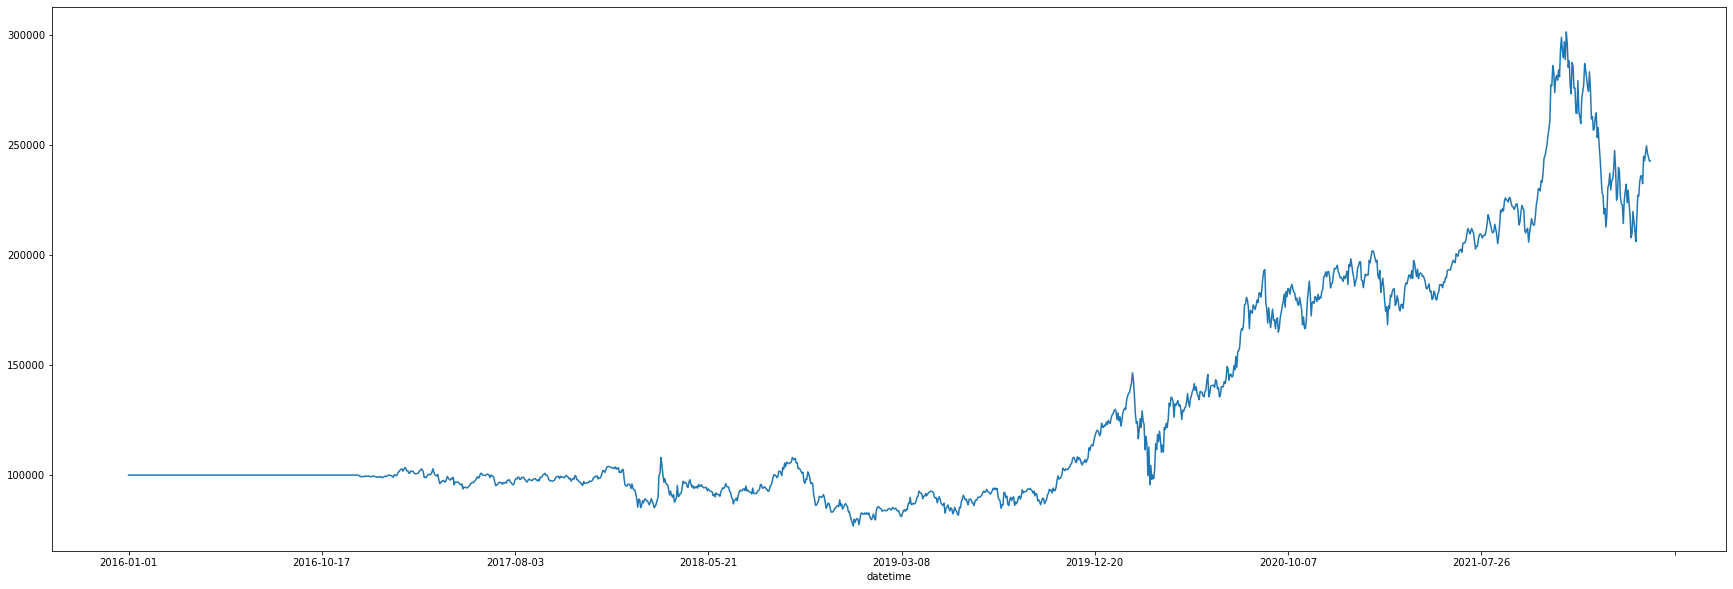

In [15]:
fig = plt.figure(figsize = (30,10))
curve.total.plot()